# Fachprojekt Machine Learning
Authors: Anastasiia Korzhylova, Ivan Shishkin, Ramneek Agnihotri, Rodi Mehi

**Due date:** Wednesday, 1. May 2024

## Import necessary components

100%|██████████| 170498071/170498071 [00:03<00:00, 42684576.11it/s]


Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified


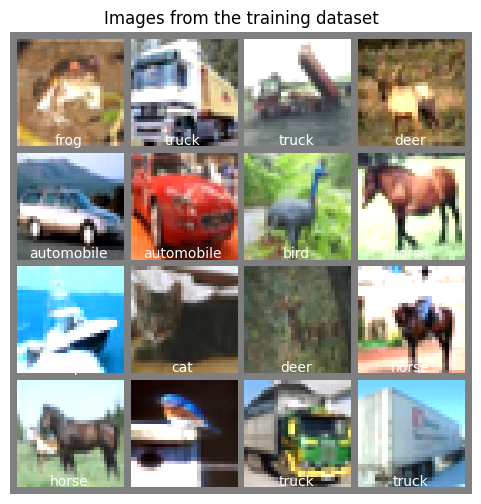

In [1]:
# Import the necessary libraries
import time
import matplotlib.pyplot as plt
import torch, torch.nn as nn
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import StepLR, ExponentialLR, CosineAnnealingLR

# Import the training and the testing datasets
from datasets import training_dataset, test_dataset

# Import the evaluation and the sampling function
from evaluation import evaluate
from sampling import sample

# Import the VAE model
import networks

## Set the hyperparameters, learning strategy, optimizer

In [3]:
# Hyperparameters
batch_size = 64 # Number of images per update of the network
num_epochs = 20 # One epoch means seeing every image of the training dataset, which consists of 50000 images
latent_dim = 100  # Size of the latent space
input_channels = 3  # CIFAR-10 images have 3 color channels

# Select the device that will be used for training: GPU, if available, otherwise CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')
print('=========================================')

# Put the neural network on the selected device
model = networks.VAE(input_channels, latent_dim)
model.to(device)

# Optimizer selection
optimizer_option = 'rmsprop'
learning_rate = 0.001

optimizer = None
if optimizer_option == "adam":
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
elif optimizer_option == "adamw":
  optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
elif optimizer_option == "rmsprop":
  optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate)
else:
  optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

# Learning rate scheduler parameters
lr_schedule_option = 'cosine'

scheduler = None
if lr_schedule_option == 'step':
  scheduler = StepLR(optimizer, step_size=30, gamma=0.5)
elif lr_schedule_option == 'exponential':
  scheduler = ExponentialLR(optimizer, gamma=0.9)
elif lr_schedule_option == 'cosine':
  scheduler = CosineAnnealingLR(optimizer, T_max=50, eta_min=0.0001)

# Scaler for AMP
scaler = torch.cuda.amp.GradScaler()

# Create data loaders for training and testing with the batch size from above.
# They can do things like multiprocessing and shuffling the order of the images.
# We can iterate over them to obtain batches of images and labels (see training loop below).
training_loader = DataLoader(dataset=training_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

Using device: cuda


## Training loop

/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch 1, Mean Test Loss: 45678.25196061781, Learning Rate: 0.001000, Time: 39.54s


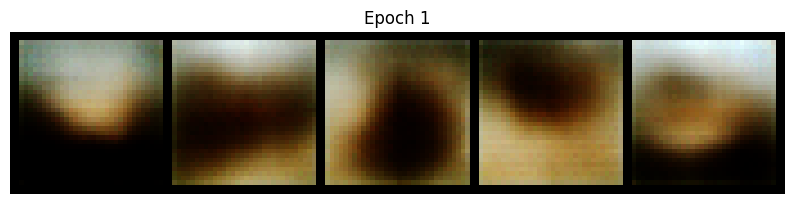

Epoch 2, Mean Test Loss: 41452.674065397216, Learning Rate: 0.000999, Time: 38.91s


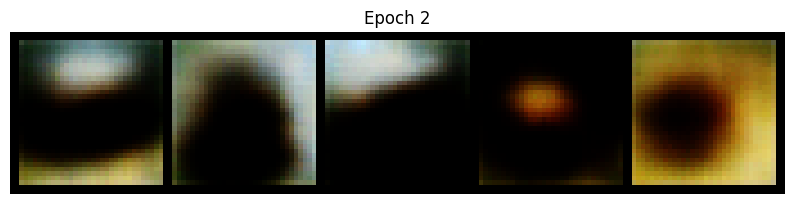

Epoch 3, Mean Test Loss: 39889.319749290684, Learning Rate: 0.000996, Time: 38.64s


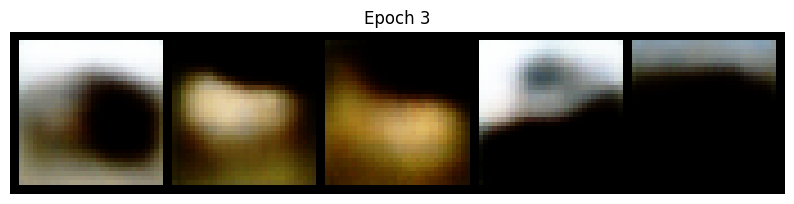

Epoch 4, Mean Test Loss: 38793.366584953445, Learning Rate: 0.000992, Time: 37.71s


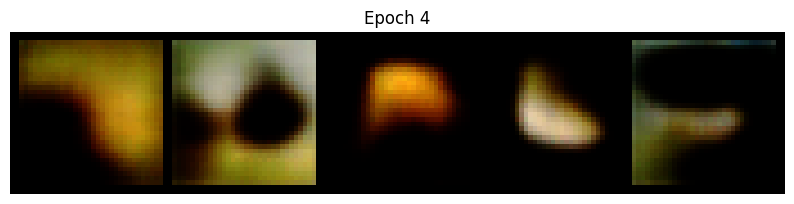

Epoch 5, Mean Test Loss: 38306.73207658148, Learning Rate: 0.000986, Time: 38.04s


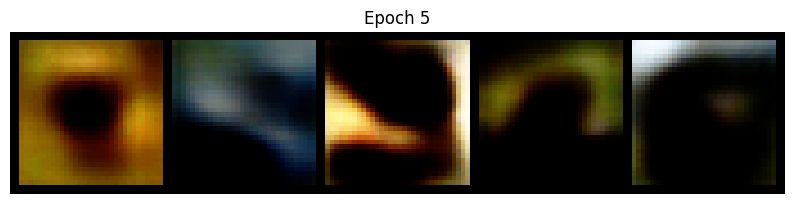

Epoch 6, Mean Test Loss: 37853.88339256813, Learning Rate: 0.000978, Time: 38.55s


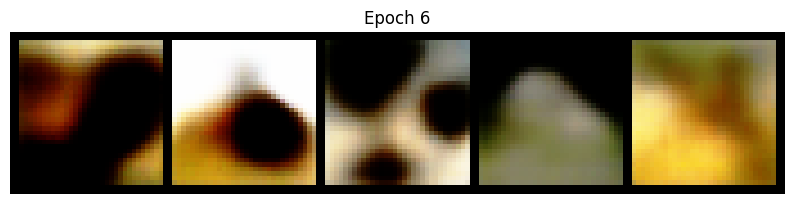

Epoch 7, Mean Test Loss: 37565.00340735394, Learning Rate: 0.000968, Time: 39.23s


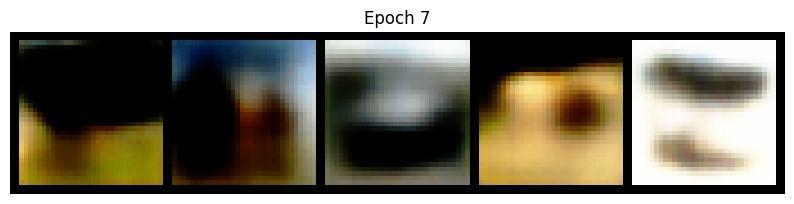

Epoch 8, Mean Test Loss: 37098.81426518043, Learning Rate: 0.000957, Time: 40.23s


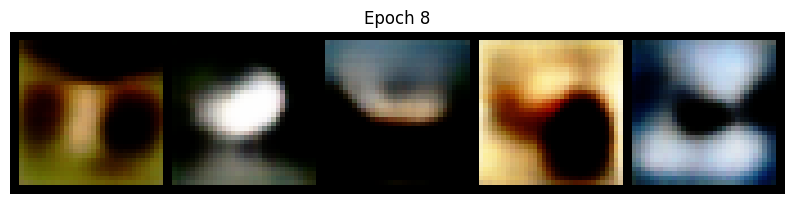

Epoch 9, Mean Test Loss: 36748.05689912684, Learning Rate: 0.000944, Time: 37.97s


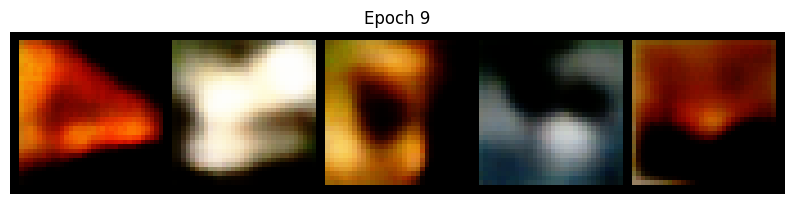

Epoch 10, Mean Test Loss: 36693.50834448929, Learning Rate: 0.000930, Time: 38.25s


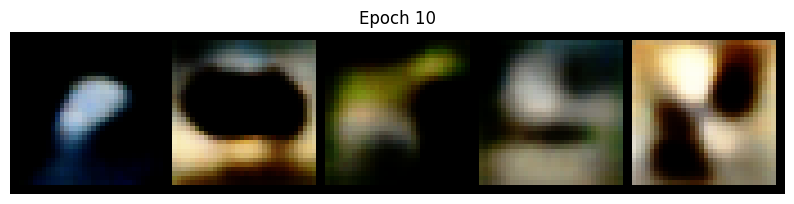

Epoch 11, Mean Test Loss: 36371.851924652336, Learning Rate: 0.000914, Time: 38.42s


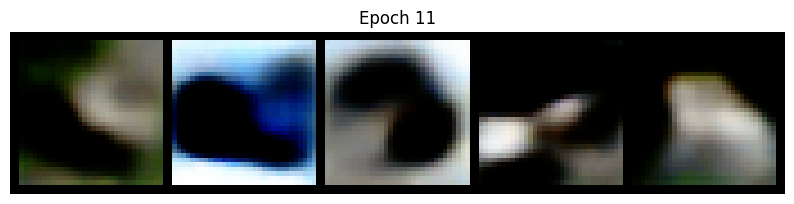

Epoch 12, Mean Test Loss: 36437.496799947054, Learning Rate: 0.000897, Time: 38.14s


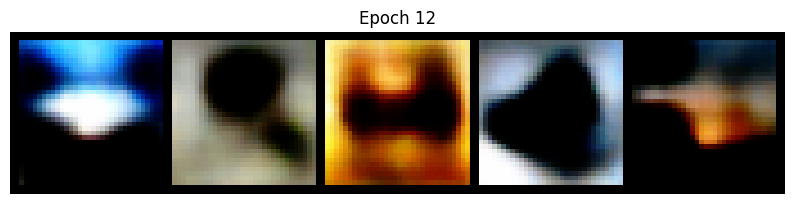

Epoch 13, Mean Test Loss: 36206.79670204104, Learning Rate: 0.000878, Time: 38.17s


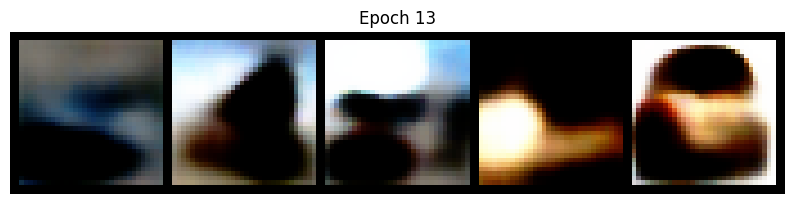

Epoch 14, Mean Test Loss: 36069.368302679424, Learning Rate: 0.000858, Time: 38.80s


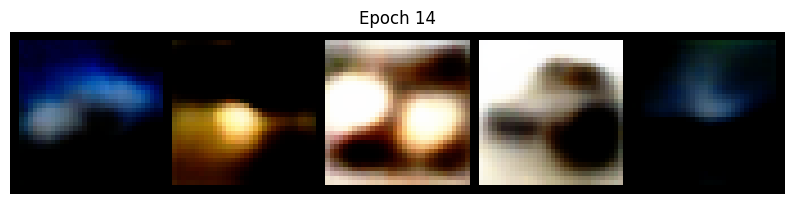

Epoch 15, Mean Test Loss: 35936.844945102705, Learning Rate: 0.000837, Time: 37.88s


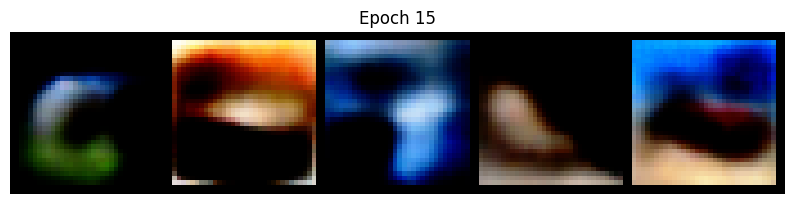

Epoch 16, Mean Test Loss: 35937.53282661145, Learning Rate: 0.000815, Time: 40.22s


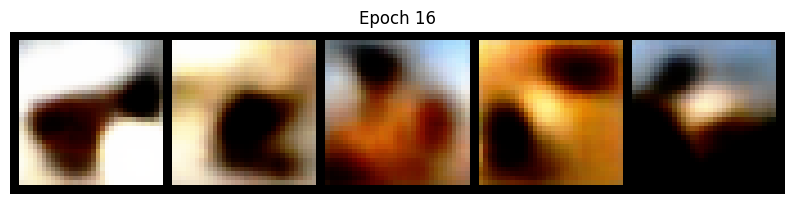

Epoch 17, Mean Test Loss: 35757.647627028055, Learning Rate: 0.000791, Time: 37.72s


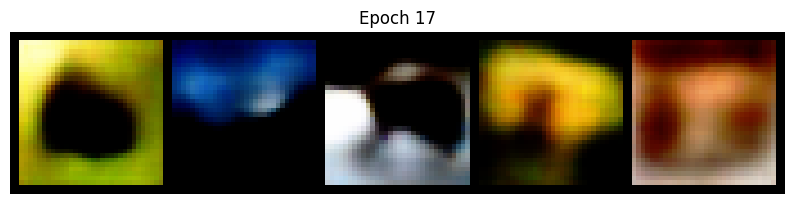

Epoch 18, Mean Test Loss: 35677.272842446255, Learning Rate: 0.000767, Time: 39.45s


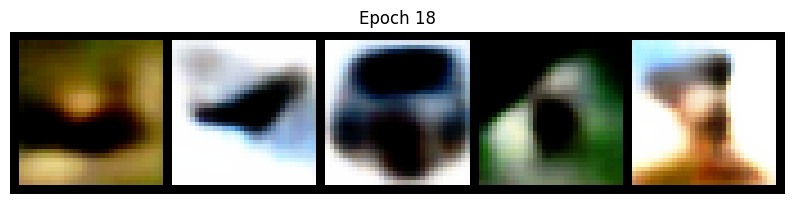

Epoch 19, Mean Test Loss: 35505.065518352385, Learning Rate: 0.000742, Time: 39.53s


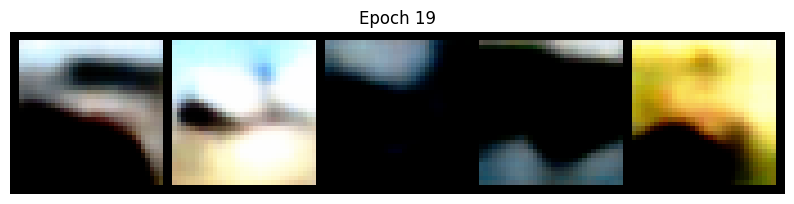

Epoch 20, Mean Test Loss: 35468.32370549273, Learning Rate: 0.000716, Time: 38.17s


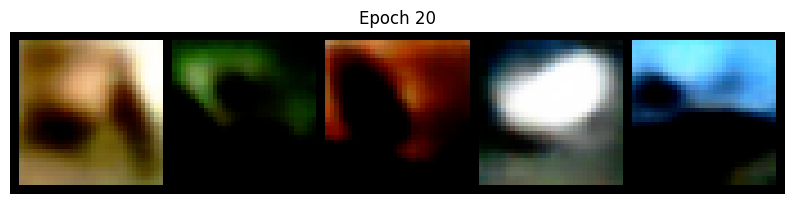

In [4]:
# Loss function
def loss_function(recon_x, x, mu, logvar):
    MSE = nn.functional.mse_loss(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return MSE + KLD

# We want to plot training and testing losses at the end of training
train_losses = []
test_losses = []
learning_rates = []

# Training loop
for epoch in range(num_epochs):
  model.train()
  epoch_start_time = time.time()

  for batch_idx, (data, _) in enumerate(training_loader):
    data = data.to(device)
    optimizer.zero_grad()

    with torch.cuda.amp.autocast():
      # Forward pass
      recon_batch, mu, logvar = model.forward(data)

      # Compute loss
      loss = loss_function(recon_batch, data, mu, logvar)
      train_losses.append(loss)

    # Backward pass
    scaler.scale(loss).backward()

    # Optimization step
    scaler.step(optimizer)
    scaler.update()

  # Step the learning rate scheduler
  if scheduler is not None:
    lr = scheduler.get_last_lr()[0]
    scheduler.step()
  else:
    lr = learning_rate
  learning_rates.append(lr)

  # After the epoch, evaluate the accuracy on the test dataset
  mean_loss = evaluate(model, test_loader, loss_function, device)
  test_losses.append(mean_loss)

  elapsed_time = time.time() - epoch_start_time
  print(f'Epoch {epoch + 1}, Mean Test Loss: {mean_loss}, Learning Rate: {lr:.6f}, Time: {elapsed_time:.2f}s')

  # Generate and log images after each epoch
  sample(model, epoch, device, latent_dim, num_samples=5)

# # Plot train and test losses
# plt.figure(figsize=(10, 5))
# plt.plot(train_losses.cpu().numpy(), label='Train Loss')
# plt.scatter(range(len(test_losses.cpu().numpy())), test_losses.cpu().numpy(), color='red', label='Test Loss')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.legend()
# plt.title('Train and Test Loss over Epochs')
# plt.show()

# # Plot learning rate over time
# plt.figure(figsize=(10, 5))
# plt.plot(learning_rates, label='Learning Rate')
# plt.xlabel('Batches')
# plt.ylabel('Learning Rate')
# plt.legend()
# plt.title('Learning Rate over Time')
# plt.show()